# Analyze the 1000 Genome Mosaic Outputs
Idea: Analyse a large number of samples together, and prepare summary plots.

This codes assumes that the Simulation as well as the HMM Calling has been done, and that the files have been saved according to the guidelines. This code here loads these files, post-process them and provides summary level statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec

# Pre-Process

## First some Functions to Load and Pre-process the data

In [2]:
#############################################
### Functions for Loading

def provide_iid_folders(folder, ch=3, nr_iid = 20, blen_cm = 1, output_prefix = ""):
    """Return a list of folders into which replicate simulations are saved into
    folder: Full folder of the analysis
    ch: Which Chromosome was analyzed
    nr_iid: How many replicate Individual were produced
    bl_cm: The length of the analyzed block class in cM
    output_prefix: Prefix before the File"""
    
    path_1 = "ch" + str(ch) + "_" + str(int(blen_cm)) + "cm/output/"  # The first part of the Path
    path_2 = "/chr" + str(ch) + "/" + output_prefix # The last part of the Path (within the folder)
    iid_list = ["iid" + str(i) for i in range(nr_iid)]  # The middle parts of the path
    
    full_paths = [(folder + path_1 + str(i) + path_2)  for i in iid_list]
    return full_paths

def load_observed(path, file="roh.csv"):
    """ Load simulated Dataframe from path"""
    df = pd.read_csv(path + file, sep=",")  # Load the Meta File
    return df

def load_simulated(path, file="roh_gt.csv"):
    """ Load Ground Truth Dataframe from path"""
    df = pd.read_csv(path + file, sep="\t")  # Load the Meta File
    return df

#############################################
### Functions for Analysis

def find_overlap(l, min_l, max_l):
    """ Find overlap of Interval l with intervals starting at min_l and ending at max_l
    Return max overlap as well as Block length (or 0 and 0 if no overlap)
    l: Interval [Length 2 list]
    min_l: Minimum Interval Lengths
    max_l: Maximum Interval Lengths"""
    
    min_both = np.maximum(l[0], min_l)
    max_both = np.minimum(l[1], max_l)  
    overlap = max_both - min_both   # Calculate the Overlap
    
    i = np.argmax(overlap)
    max_overlap = overlap[i]
    
    if max_overlap < 0:
        return 0., 0.   # Return 0 Overlap and 0 total length
    
    else:
        orginal_length = max_l[i] - min_l[i]
        return max_overlap, orginal_length
    
    
def check_obs_vrs_sim(df_o, df_s):
    """Analyze observed . 
    Input: 2 Dataframes
    Output: 1 Dataframe
    Return: One dateframe with intersecting [Overlap, CalledLength, Position]"""
    
    begin_obs = df_o["StartM"].values * 100  # Factor 100: To do everything in centiMorgan
    end_obs = df_o["EndM"].values * 100

    overlaps = np.zeros(len(df_s))
    lengths = np.zeros(len(df_s))

    for i, row in df_s.iterrows():
        roh = [row["ROH_Begin"] * 100, row["ROH_End"] * 100]
        ovlp, lgth = find_overlap(roh, begin_obs, end_obs)  # Find the Overlap

        overlaps[i] = ovlp
        lengths[i] = lgth

    df_call = pd.DataFrame({"Overlap": overlaps, "CalledLength":lengths, 
                            "Position": df_s["ROH_Begin"].values * 100, "iid":df_s["iid"]})

    ###  Create df with Original Length, Found Length, Position, Overlap (Fraction)  
    return df_call

def collect_power_df(mosaic_folder = "../../Simulated/1000G_Mosaic/TSI/", ch=3, nr_iid = 20, blen_cm = 3, output_prefix=""):
    """Create and return the Dataframe with the Power.
    Check every simulated block for overlap."""
    folders = provide_iid_folders(folder = mosaic_folder, ch=ch, nr_iid = nr_iid, 
                                  blen_cm = blen_cm, output_prefix=output_prefix)   # Load all the folders
    df_calls = []

    for f in folders:   
        df_o = load_observed(f)   # Loading should throw error if not existend
        df_s = load_simulated(f)

        df_call = check_obs_vrs_sim(df_o, df_s)
        df_calls.append(df_call)

    df_calls = pd.concat(df_calls)   # Concatenate all the Results
    return df_calls

def collect_fp_df(mosaic_folder = "../../Simulated/1000G_Mosaic/TSI/", ch=3, nr_iid = 20, blen_cm = 3, output_prefix = ""):
    """Collect and return the Dataframe with the false positive Calls"""
    folders = provide_iid_folders(folder = mosaic_folder, ch=ch, nr_iid = nr_iid, 
                                  blen_cm = blen_cm, output_prefix=output_prefix)   # Load all the folders
    
    observed_dfs = [load_observed(f) for f in folders]
    df_observed = pd.concat(observed_dfs)
    return df_observed


#############################################
### Post-Processing the Call Dataframe

def statistics_power_df(df):
    """Report some statistics on the Power Dataframe"""
    l = len(set(df["iid"]))
    no_calls = df["Overlap"]<0.01
    df_c = df[~no_calls]  # The Dataframe with the lenghts called
    mean_called = np.mean(df_c["CalledLength"])
    
    print(f"{l} unique Individuals")
    print(f"{len(df)} total blocks tested")
    print(f"{np.sum(no_calls)} Blocks not called")
    print(f"{mean_called:.4f} average Block Length cM (called)")
        
def calc_power(df):
    """Calculate and return the Power from the Calling Dataframe"""
    
    no_calls = np.sum(df["Overlap"]<0.01)
    power = 1  - (no_calls / len(df))
    return power

def return_calls_only(df):
    """Return Dataframe of only called Blocks"""
    no_calls = df["Overlap"]<0.01
    df_c = df[~no_calls]  # The Dataframe with the lenghts called
    return(df_c)

def false_power_statistics(df):
    '''Report some statistics on the false Power Dataframe'''
    bl_lens = df["lengthM"].values
    
    
    print(f"Found {len(bl_lens)} FP blocks")
    print(f"Average Block length: {np.mean(bl_lens):.4f} cM")
    print(f"Maximum Block length: {np.max(bl_lens):.4f} cM")

In [4]:
df_calls = collect_power_df(mosaic_folder = "../../Simulated/1000G_Mosaic/TSI2/", ch=3, nr_iid = 50, blen_cm = 3)

In [6]:
statistics_power_df(df_calls)
calc_power(df_calls)

50 unique Individuals
250 total blocks tested
0 Blocks not called
3.1449 average Block Length cM (called)


1.0

# Figures
### Idea: 
- Top Panel: False Positive Rate
- Middle Panel: False Negative Rate
- Lower Panel: Power Curves

# Power and Error Plot

- Uper Panel: Power Curve
- Lower Panel: Power Curves

In [7]:
bl_lens = [1, 3, 6, 10]   # The Length of the Blocks

### Extract Colors from Viridis
cmap = cm.get_cmap("viridis_r")
colors = [cmap(x) for x in np.linspace(0,1, len(bl_lens))]

### Extract the Pandas Dataframes for called blocks
df_call_vec = [collect_power_df(mosaic_folder = "../../Simulated/1000G_Mosaic/TSI2/", ch=3, nr_iid = 50, blen_cm = l) 
            for l in bl_lens]

powers = [calc_power(df) for df in df_call_vec]   # Calculate the Power per Block Length
df_call_vec1 = [return_calls_only(df) for df in df_call_vec]   # Only Keep the called blocks for plotting

bins = np.linspace(0, 15, 75)  # Bins of 0.1 cM

In [13]:
def load_power_dfs(mosaic_folder, bl_lens, output_prefix=""):
    """Load the Power dfs"""
    ### Extract Colors from Viridis
    cmap = cm.get_cmap("viridis_r")
    colors = [cmap(x) for x in np.linspace(0,1, len(bl_lens))]

    ### Extract the Pandas Dataframes for called blocks
    df_call_vec = [collect_power_df(mosaic_folder = mosaic_folder, ch=3, nr_iid = 20, 
                                    blen_cm = l, output_prefix=output_prefix) for l in bl_lens]

    powers = [calc_power(df) for df in df_call_vec]   # Calculate the Power per Block Length
    df_call_vec1 = [return_calls_only(df) for df in df_call_vec]   # Only Keep the called blocks for plotting

    bins = np.linspace(0, 15, 75)  # Bins of 0.1 cM
    
    return df_call_vec, df_call_vec1

def plot_power(fs = 14, fs_l=12, xlim=(0,13), figsize=(10,6), bl_lens=[1, 3, 5, 10], 
               mosaic_folder = "../../Simulated/1000G_Mosaic/TSI/", output_prefix = "", save=True, title=""):
    """Plot power and power curves"""
    
    df_call_vec, df_call_vec1 = load_power_dfs(mosaic_folder, output_prefix=output_prefix, bl_lens = bl_lens)
    
    
    plt.figure(figsize=figsize)

    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4])
    gs.update(hspace=0.04) # set the spacing between axes. 


    ax = plt.subplot(gs[1]) # The lower subplot
    ax1 = plt.subplot(gs[0]) # The upper subplot

    # Plot All Histograms
    for i in range(len(bl_lens)):
        l = bl_lens[i]
        ax.hist(df_call_vec1[i]["CalledLength"], bins = bins, color = colors[i], alpha=0.9, label= str(l) + " cM", ec="silver")
        ax.axvline(l, color = "gray", linewidth=2)

    ax.set_xlim(xlim)
    ax.set_xlabel("Inferred block Length [cM]", fontsize = fs)
    ax.set_ylabel("# Inferred", fontsize = fs)
    ax.legend(loc = "upper right", fontsize = fs_l)

    ax1.set_ylabel("Power", fontsize = fs)
    ax1.set_xticks([])
    ax1.scatter(bl_lens, powers, c=colors, s=100,zorder=1)
    ax1.plot(bl_lens, powers, "gray", zorder=0)
    ax1.set_xlim(xlim)

    plt.title(title, fontsize=fs)
    
    if save == True:
        plt.savefig("../../figures/Power/tsi20.png")
    plt.show()

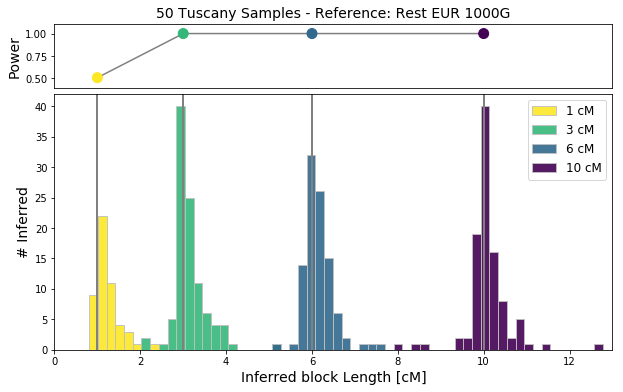

In [14]:
title = "50 Tuscany Samples - Reference: Rest EUR 1000G"
plot_power(bl_lens=[1, 3, 6, 10], mosaic_folder = "../../Simulated/1000G_Mosaic/TSI2/", output_prefix = "", 
           save=False, title=title)

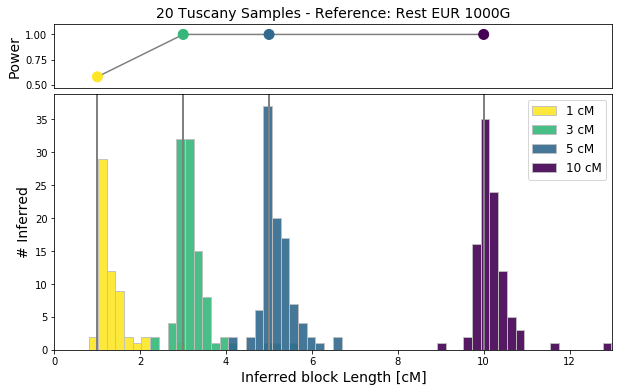

In [10]:
plot_power(bl_lens=[1, 3, 5, 10], mosaic_folder = "../../Simulated/1000G_Mosaic/TSI/", output_prefix = "baseline/", save=False)

# False Positive Plot

In [17]:
def plot_fp_distribution(fs = 14, fs_l = 12, bins = np.linspace(1, 3, 26), xlim = (0, 13), figsize = (10, 4),
                        title = "100 Mosaic Tuscany Samples - Reference: Rest EUR 1000G", 
                         mosaic_folder = "../../Simulated/1000G_Mosaic/TSI/", ch=3, nr_iid = 100, blen_cm = 0):
    """ Plot the Distribution of false positive ROH calls"""
    
    df_call_fp = collect_fp_df(mosaic_folder = mosaic_folder, ch = ch, nr_iid = nr_iid, blen_cm = blen_cm)
    false_power_statistics(df_call_fp)  # Do give some written statistics
    
    
    ### The Actual Plot
    plt.figure(figsize=figsize)

    ax = plt.gca()
    ax.hist(df_call_fp["lengthM"] * 100, bins = bins, color = colors[2], alpha=0.9, ec="silver")

    plt.title(title, fontsize=fs)
    ax.set_xlabel("Inferred block Length [cm]", fontsize=fs)
    ax.set_ylabel("Count", fontsize=fs)
    plt.show()

Found 163 FP blocks
Average Block length: 0.0124 cM
Maximum Block length: 0.0207 cM


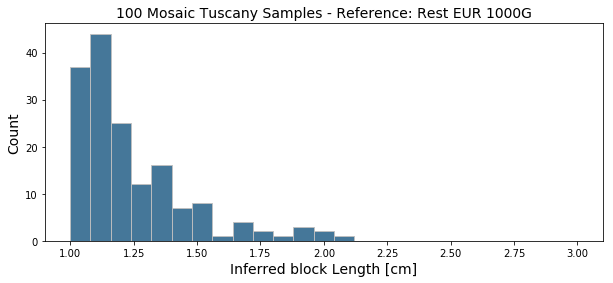

In [18]:
plot_fp_distribution()

# Area 51

### Testing of Functions

In [96]:
### Function went into production. Can delete

df = load_observed("../../Simulated/1000G_Mosaic/TSI/ch3_10cm/output/iid0/chr3/")
df_n = df.drop(df.index)  # Create New Data frame with all raws removed

row_c = df.iloc[0, :].copy()
max_gap = 0.01

### Iterate over all rows, update blocks if gaps small enough
for index, row in df.iterrows():
    if row["StartM"] - row_c["EndM"] < max_gap:
        row_c["End"] = row["End"]
        row_c["EndM"] = row["EndM"]
        row_c["length"]  = row_c["End"] - row_c["Start"]
        row_c["lengthM"] = row_c["EndM"] - row_c["StartM"] 
        
    else:     ### Save and go to next row
        df_n.loc[len(df_n)] = row_c
        row_c = row.copy()

df_n.loc[len(df_n)] = row_c


print(f"Merged n={len(df) - len(df_n)} gaps < {max_gap} M")

Merged n=0 gaps < 0.01 M


In [95]:
df

,Start,End,StartM,EndM,length,lengthM,iid,ch
0,3685,6350,0.156614,0.258285,2665,0.101671,iid0,3
1,22958,27037,0.685552,0.783397,4079,0.097845,iid0,3
2,32429,35012,0.937753,1.036958,2583,0.099205,iid0,3
3,53021,55414,1.422184,1.478951,2393,0.056767,iid0,3
4,55489,57163,1.479852,1.522091,1674,0.042239,iid0,3
5,61657,62081,1.655665,1.669167,424,0.013502,iid0,3
6,71583,73817,1.937247,2.037171,2234,0.099924,iid0,3


In [94]:
df_n

,Start,End,StartM,EndM,length,lengthM,iid,ch
0,3685,6350,0.156614,0.258285,2665,0.101671,iid0,3
1,22958,27037,0.685552,0.783397,4079,0.097845,iid0,3
2,32429,35012,0.937753,1.036958,2583,0.099205,iid0,3
3,53021,57163,1.422184,1.522091,4142,0.099907,iid0,3
4,61657,62081,1.655665,1.669167,424,0.013502,iid0,3
5,71583,73817,1.937247,2.037171,2234,0.099924,iid0,3
